In [1]:
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')

import facts
from facts.models import customLogisticRegression
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


In [3]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = ['hours-per-week']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 1.34 s
Wall time: 1.45 s


array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [6]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.74      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



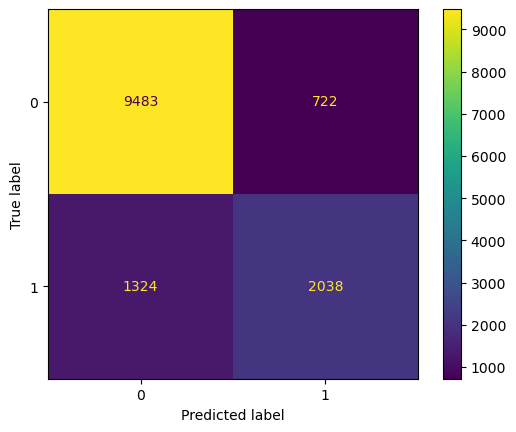

In [7]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Rules

In [9]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='race',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████| 26549/26549 [00:00<00:00, 271099.95it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|████████████████████████████████████████████████████████████████████████████| 7396/7396 [00:01<00:00, 4909.98it/s]


Computing correctenesses for all valid if-thens.


100%|████████████████████████████████████████████████████████████████████████████| 50150/50150 [24:43<00:00, 33.82it/s]


Number of if-thens: 50150


In [10]:
## Use this for loading rules from disk
# rules_by_if = load_rules_by_if("rulesAdultFairTest-race-multiple.data")
## Use this for saving rules on disk
save_rules_by_if("rulesAdultFairTest-race-multiple.data", rules_by_if)

In [11]:
num_features_ = ['education-num', 'capital-gain', 'capital-loss']
cate_features_ = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features_ = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

In [12]:
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="race", params=params)

100%|██████████████████████████████████████████████████████████████████████████████| 6772/6772 [12:13<00:00,  9.24it/s]


In [14]:
## Use this for loading rules from disk
# rules_with_cumulative = load_rules_by_if("rulesAdultFairTest-race-multiple-cumulative.data")

## Use this for saving rules on disk
save_rules_by_if("rulesAdultFairTest-race-multiple-cumulative.data", rules_with_cumulative)

In [15]:
rules_with_atomic_correctness = rules_by_if
rules_with_cumulative_correctness = rules_with_cumulative

In [16]:
feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

facts.update_costs_cumulative(rules_with_cumulative_correctness, params)

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="race", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Black', 4.41% covered out of 1203
		Make age = (41.0, 50.0], capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00%.
		Aggregate cost of the above recourses = 20.15
	Protected Subgroup ' Amer-Indian-Eskimo', 4.55% covered out of 110
		Make age = (41.0, 50.0], capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00%.
		Aggregate cost of the above recourses = 20.15
	Protected Subgroup ' Asian-Pac-Islander', 1.34% covered out of 299
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 50.00%.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Other', 4.12% covered out of 97
		Make age = (41.0, 50.0], capital-gain = 15024, marital-status =  Married-c